In [4]:
"""
Script 1: BERT Representation Extraction for 'bat' Polysemy Analysis
This script extracts hidden state representations from bert-large-uncased
using multiple strategies and saves them for downstream analysis.
"""

import torch
import pandas as pd
import numpy as np
import pickle
from transformers import BertModel, BertTokenizer
from tqdm import tqdm

def setup_environment():
    """Setup GPU and verify availability."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if device.type == 'cuda':
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    return device

def load_model_and_data(device):
    """Load BERT model, tokenizer, and CSV data."""
    print("\nLoading BERT model and tokenizer...")
    model_name = 'bert-large-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    print(f"Model loaded: {model_name}")
    print(f"Number of layers: {model.config.num_hidden_layers}")
    print(f"Hidden dimension: {model.config.hidden_size}")

    # Load CSV data
    print("\nLoading data from /content/bat-both.csv...")
    df = pd.read_csv('/content/bat-both.csv', header=None,
                     names=['sentence', 'token_index', 'char_span'])
    print(f"Data loaded: {len(df)} rows")

    # Create ground truth labels
    # Specification: first 65 rows (0-64) are baseball bat,
    # next 65 rows (65-129) are animal bat
    labels = np.array([0] * 65 + [1] * 65)

    # Verify we have 130 labels for 130 rows
    if len(df) == 132:
        # Adjust for 132 rows: 66 each
        labels = np.array([0] * 66 + [1] * 66)
    elif len(df) == 130:
        # Keep as is for 130 rows
        pass

    print(f"Labels created: {np.sum(labels == 0)} baseball bat, {np.sum(labels == 1)} animal bat")
    print(f"Total labels: {len(labels)}")

    return model, tokenizer, df, labels

def extract_embeddings(model, tokenizer, df, device):
    """
    Extract embeddings using four different strategies.
    Returns a dictionary with embeddings for each strategy.
    """
    # Initialize storage for each strategy
    embeddings = {
        'last_layer': [],      # Strategy 1: Last layer only
        'concat_l4': [],       # Strategy 2: Concatenation of last 4 layers
        'avg_l4': [],          # Strategy 3: Average of last 4 layers
        'weighted_avg_l4': []  # Strategy 4: Weighted average of last 4 layers
    }

    # Weights for weighted average (layers 21-24)
    weights = torch.tensor([0.1, 0.2, 0.3, 0.4]).to(device)

    print("\nExtracting embeddings...")

    # Track problematic sentences
    skipped_indices = []
    processed_count = 0

    # Process each sentence
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing sentences"):
        sentence = row['sentence']
        token_idx = int(row['token_index'])

        try:
            # Tokenize and encode
            inputs = tokenizer(sentence, return_tensors='pt',
                              padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Forward pass with no gradient computation
            with torch.no_grad():
                outputs = model(**inputs)

            # Get all hidden states (tuple of length 25: embeddings + 24 layers)
            all_hidden_states = outputs.hidden_states

            # Check if token_idx is valid
            seq_len = all_hidden_states[0].shape[1]
            if token_idx >= seq_len:
                print(f"\nWarning: token_index {token_idx} out of bounds for sentence {idx}")
                print(f"  Sentence length after tokenization: {seq_len}")
                print(f"  Using last valid token instead")
                token_idx = seq_len - 1

            # Extract hidden states for the target token from layers 21-24
            target_states = []
            for layer_idx in [21, 22, 23, 24]:
                hidden_state = all_hidden_states[layer_idx]  # Shape: (batch, seq_len, hidden_dim)
                token_embedding = hidden_state[0, token_idx, :].cpu().numpy()  # Extract for specific token
                target_states.append(token_embedding)

            # Strategy 1: Last layer only (layer 24)
            embeddings['last_layer'].append(target_states[-1])  # Last element is layer 24

            # Strategy 2: Concatenation of last 4 layers
            concat_embedding = np.concatenate(target_states)  # Shape: (4096,)
            embeddings['concat_l4'].append(concat_embedding)

            # Strategy 3: Average of last 4 layers
            avg_embedding = np.mean(target_states, axis=0)  # Shape: (1024,)
            embeddings['avg_l4'].append(avg_embedding)

            # Strategy 4: Weighted average of last 4 layers
            target_states_tensor = torch.tensor(np.array(target_states)).to(device)
            weighted_avg = torch.sum(target_states_tensor * weights.unsqueeze(1), dim=0)
            embeddings['weighted_avg_l4'].append(weighted_avg.cpu().numpy())

            processed_count += 1

        except Exception as e:
            print(f"\nError processing sentence {idx}: {e}")
            print(f"  Sentence: {sentence[:50]}...")
            print(f"  Token index: {token_idx}")
            skipped_indices.append(idx)

            # Add placeholder embeddings to maintain alignment
            embeddings['last_layer'].append(np.zeros(1024))
            embeddings['concat_l4'].append(np.zeros(4096))
            embeddings['avg_l4'].append(np.zeros(1024))
            embeddings['weighted_avg_l4'].append(np.zeros(1024))

        if (idx + 1) % 20 == 0:
            print(f"Processed {processed_count}/{idx + 1} sentences successfully...")

    # Convert lists to numpy arrays
    for strategy in embeddings:
        embeddings[strategy] = np.array(embeddings[strategy])
        print(f"\n{strategy} shape: {embeddings[strategy].shape}")

    if skipped_indices:
        print(f"\nWarning: {len(skipped_indices)} sentences had issues: {skipped_indices}")
    else:
        print(f"\nAll {len(df)} sentences processed successfully!")

    return embeddings, skipped_indices

def save_results(embeddings, labels, skipped_indices):
    """Save embeddings and labels to pickle file."""
    results = {
        'embeddings': embeddings,
        'labels': labels,
        'skipped_indices': skipped_indices
    }

    output_file = 'bat_embeddings.pkl'
    with open(output_file, 'wb') as f:
        pickle.dump(results, f)

    print(f"\nResults saved to {output_file}")
    print(f"File contains:")
    print(f"  - Embeddings for 4 strategies")
    print(f"  - Ground truth labels (shape: {labels.shape})")
    print(f"  - Skipped indices: {len(skipped_indices)}")

def main():
    """Main execution function."""
    print("="*60)
    print("BERT Representation Extraction for 'bat' Polysemy Analysis")
    print("="*60)

    # Setup
    device = setup_environment()

    # Load model and data
    model, tokenizer, df, labels = load_model_and_data(device)

    # Extract embeddings
    embeddings, skipped_indices = extract_embeddings(model, tokenizer, df, device)

    # Save results
    save_results(embeddings, labels, skipped_indices)

    print("\n" + "="*60)
    print("Extraction complete! Run Script 2 for analysis.")
    print("="*60)

if __name__ == "__main__":
    main()

BERT Representation Extraction for 'bat' Polysemy Analysis
Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB

Loading BERT model and tokenizer...
Model loaded: bert-large-uncased
Number of layers: 24
Hidden dimension: 1024

Loading data from /content/bat-both.csv...
Data loaded: 129 rows
Labels created: 65 baseball bat, 65 animal bat
Total labels: 130

Extracting embeddings...


Processing sentences:  24%|██▍       | 31/129 [00:00<00:01, 59.61it/s]

Processed 20/20 sentences successfully...


Processing sentences:  33%|███▎      | 43/129 [00:00<00:01, 49.01it/s]

Processed 40/40 sentences successfully...


Processing sentences:  50%|████▉     | 64/129 [00:01<00:01, 45.67it/s]

Processed 60/60 sentences successfully...


Processing sentences:  69%|██████▉   | 89/129 [00:01<00:00, 45.98it/s]

Processed 80/80 sentences successfully...


Processing sentences:  81%|████████  | 104/129 [00:02<00:00, 45.19it/s]

Processed 100/100 sentences successfully...


Processing sentences:  96%|█████████▌| 124/129 [00:02<00:00, 38.75it/s]

Processed 120/120 sentences successfully...


Processing sentences: 100%|██████████| 129/129 [00:02<00:00, 44.98it/s]


last_layer shape: (129, 1024)

concat_l4 shape: (129, 4096)

avg_l4 shape: (129, 1024)

weighted_avg_l4 shape: (129, 1024)

All 129 sentences processed successfully!

Results saved to bat_embeddings.pkl
File contains:
  - Embeddings for 4 strategies
  - Ground truth labels (shape: (130,))
  - Skipped indices: 0

Extraction complete! Run Script 2 for analysis.


Enhanced Clustering and Visualization Analysis for 'bat' Polysemy

Loading embeddings from bat_embeddings.pkl...
Loading original sentences from /content/bat-both.csv...
Loaded embeddings for 4 strategies
Ground truth labels shape: (130,)
Original sentences: 129 rows
Mismatch between embeddings (129) and labels (130)
Truncated labels to 129
Label distribution: 65 baseball bat, 64 animal bat

Analyzing Strategy: Last Layer Only
Embedding shape: (129, 1024)

OUTLIER AND CENTROID ANALYSIS

Top 5 Outliers/Ambiguous Sentences:
------------------------------------------------------------

1. Sentence #32 [Correctly classified]
   True: baseball bat, Predicted: baseball bat
   Distance to assigned cluster: 9.9800
   Ambiguity score: 1.7344
   Sentence: "Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy defenses ..."

2. Sentence #121 [Correctly classified]
   True: animal bat, Predicted: animal bat
   Distance to assigned cluster: 8.4078
   Ambiguity s

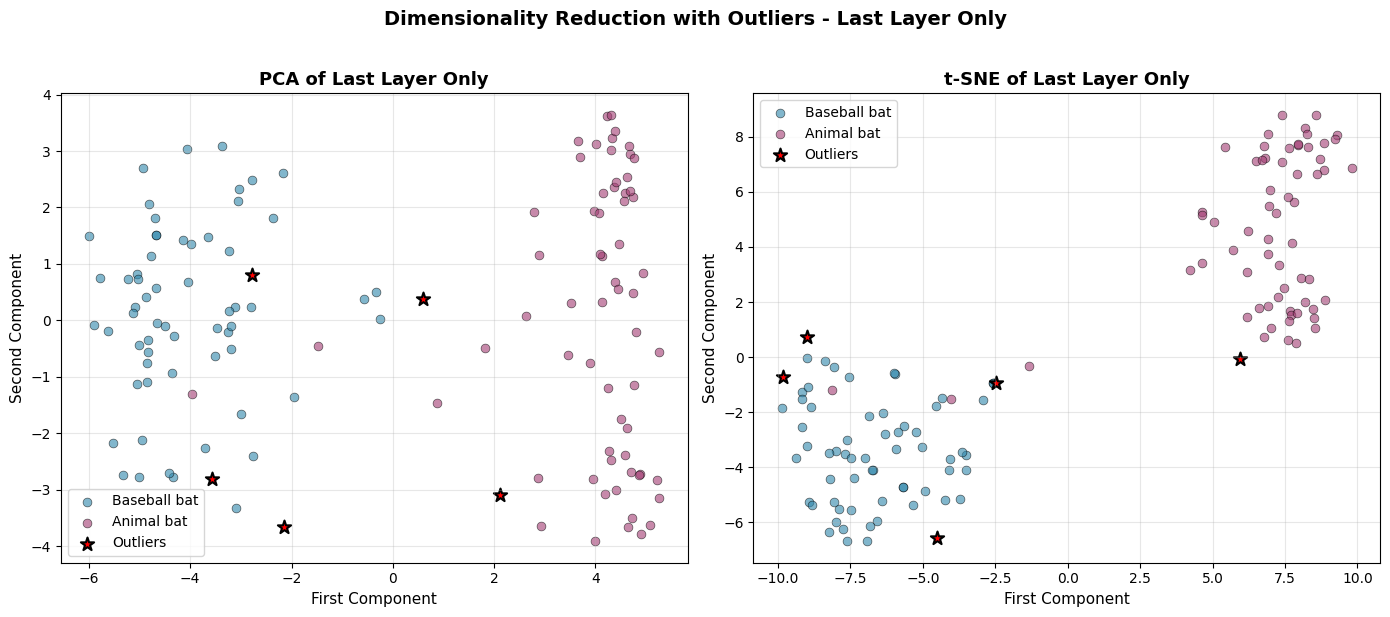


CLUSTERING EVALUATION
--- Analysis for Strategy: Last Layer Only ---
Adjusted Rand Index (ARI): 0.9084
Normalized Mutual Information (NMI): 0.8425
Cluster Purity: 0.9767
Cluster sizes: [66, 63]


Misclassified samples: 3/129 (2.3%)
Analyzing Strategy: Concatenation of Last 4 Layers
Embedding shape: (129, 4096)

OUTLIER AND CENTROID ANALYSIS

Top 5 Outliers/Ambiguous Sentences:
------------------------------------------------------------

1. Sentence #32 [Correctly classified]
   True: baseball bat, Predicted: baseball bat
   Distance to assigned cluster: 29.7364
   Ambiguity score: 5.7492
   Sentence: "Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy defenses ..."

2. Sentence #121 [Correctly classified]
   True: animal bat, Predicted: animal bat
   Distance to assigned cluster: 26.2540
   Ambiguity score: 6.2894
   Sentence: "The vampire's cape fluttered like bat wings as he emerged from his coffin on Halloween night."

3. Sentence #2 [Correc

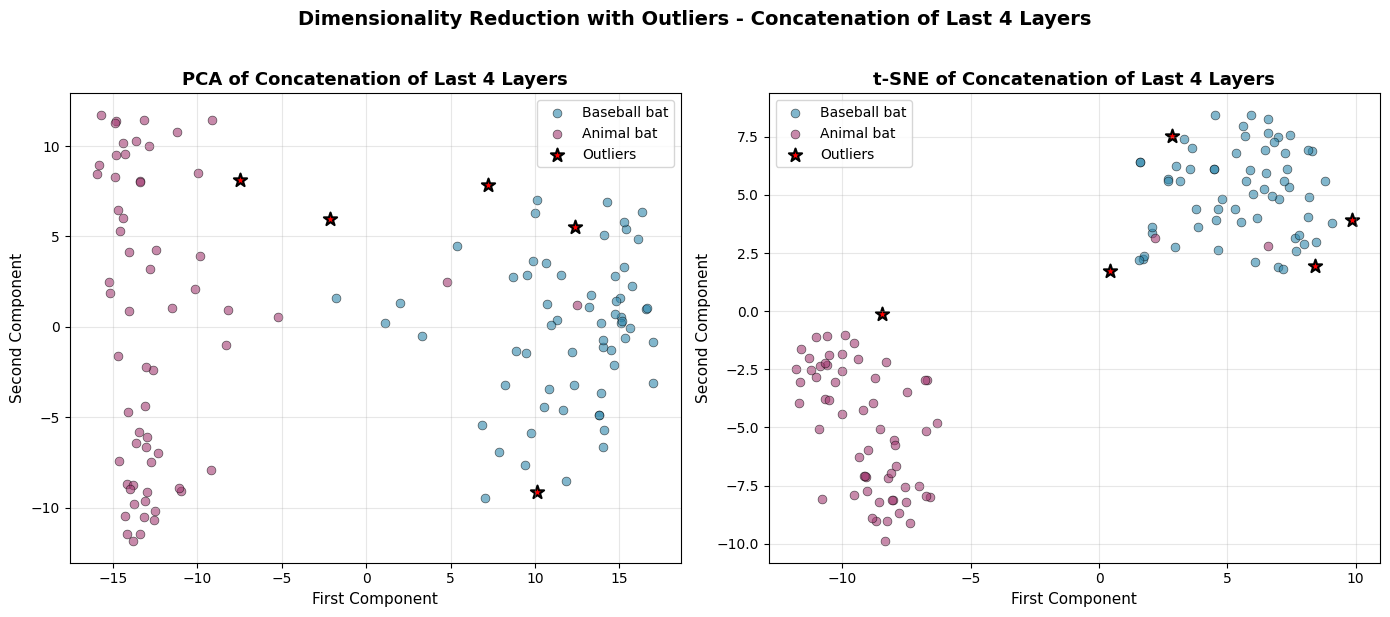


CLUSTERING EVALUATION
--- Analysis for Strategy: Concatenation of Last 4 Layers ---
Adjusted Rand Index (ARI): 0.9084
Normalized Mutual Information (NMI): 0.8425
Cluster Purity: 0.9767
Cluster sizes: [66, 63]


Misclassified samples: 3/129 (2.3%)
Analyzing Strategy: Average of Last 4 Layers
Embedding shape: (129, 1024)

OUTLIER AND CENTROID ANALYSIS

Top 5 Outliers/Ambiguous Sentences:
------------------------------------------------------------

1. Sentence #32 [Correctly classified]
   True: baseball bat, Predicted: baseball bat
   Distance to assigned cluster: 13.8843
   Ambiguity score: 2.8335
   Sentence: "Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy defenses ..."

2. Sentence #121 [Correctly classified]
   True: animal bat, Predicted: animal bat
   Distance to assigned cluster: 12.3279
   Ambiguity score: 2.8863
   Sentence: "The vampire's cape fluttered like bat wings as he emerged from his coffin on Halloween night."

3. Sentence #

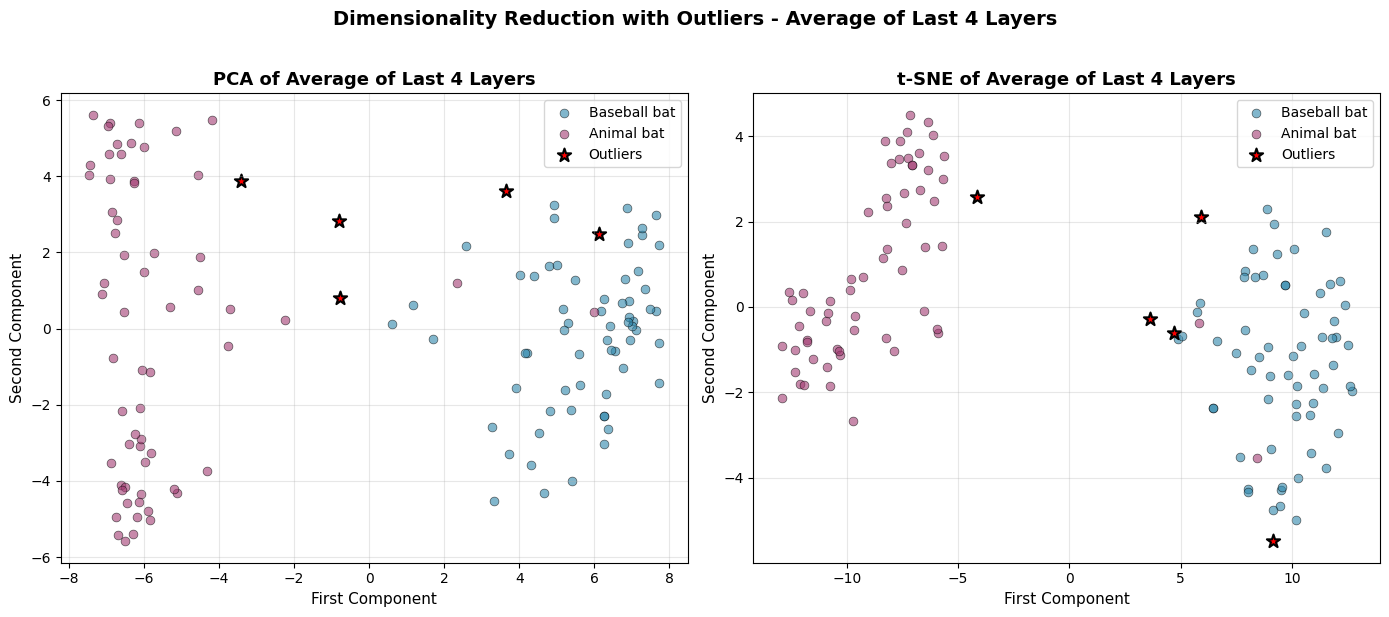


CLUSTERING EVALUATION
--- Analysis for Strategy: Average of Last 4 Layers ---
Adjusted Rand Index (ARI): 0.9084
Normalized Mutual Information (NMI): 0.8425
Cluster Purity: 0.9767
Cluster sizes: [66, 63]


Misclassified samples: 3/129 (2.3%)
Analyzing Strategy: Weighted Average of Last 4 Layers
Embedding shape: (129, 1024)

OUTLIER AND CENTROID ANALYSIS

Top 5 Outliers/Ambiguous Sentences:
------------------------------------------------------------

1. Sentence #32 [Correctly classified]
   True: baseball bat, Predicted: baseball bat
   Distance to assigned cluster: 13.1357
   Ambiguity score: 2.4128
   Sentence: "Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy defenses ..."

2. Sentence #121 [Correctly classified]
   True: animal bat, Predicted: animal bat
   Distance to assigned cluster: 11.3901
   Ambiguity score: 2.7061
   Sentence: "The vampire's cape fluttered like bat wings as he emerged from his coffin on Halloween night."

3. Sentenc

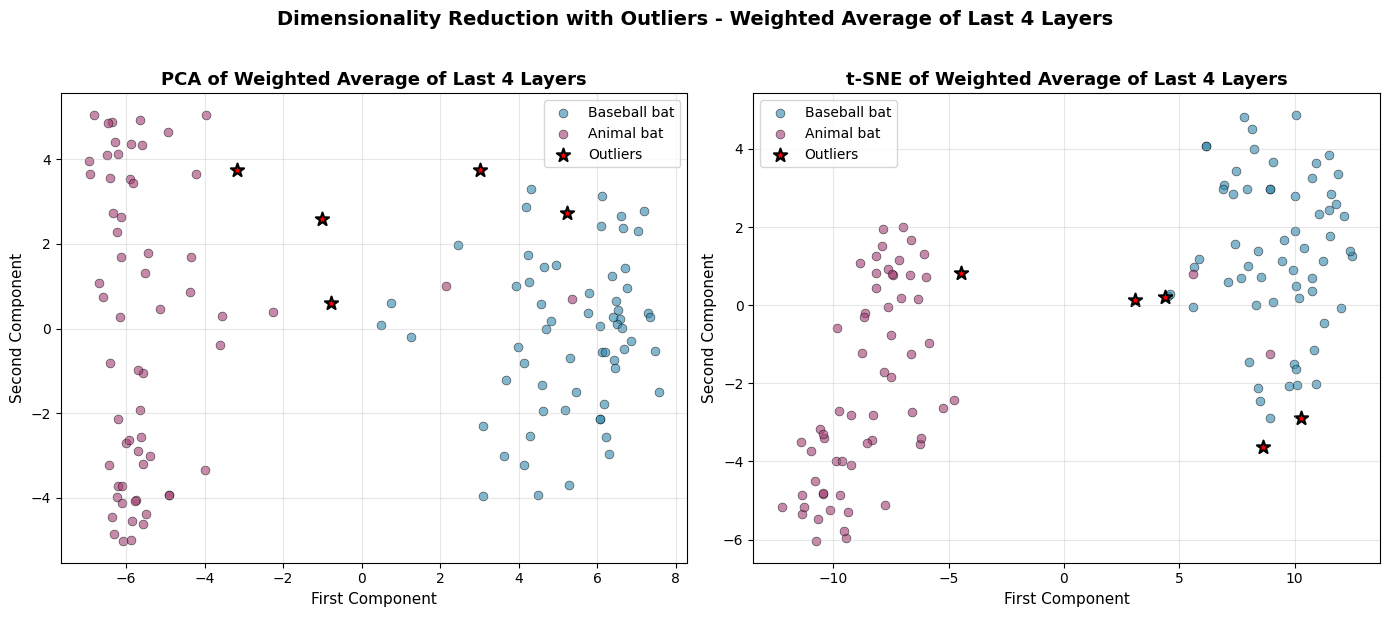


CLUSTERING EVALUATION
--- Analysis for Strategy: Weighted Average of Last 4 Layers ---
Adjusted Rand Index (ARI): 0.9084
Normalized Mutual Information (NMI): 0.8425
Cluster Purity: 0.9767
Cluster sizes: [66, 63]


Misclassified samples: 3/129 (2.3%)

SUMMARY: Comparison of All Strategies
Strategy                                      ARI      NMI   Purity
------------------------------------------------------------
Last Layer Only                            0.9084   0.8425   0.9767
Concatenation of Last 4 Layers             0.9084   0.8425   0.9767
Average of Last 4 Layers                   0.9084   0.8425   0.9767
Weighted Average of Last 4 Layers          0.9084   0.8425   0.9767

Best performing strategy (by ARI): Last Layer Only
ARI Score: 0.9084

OUTLIERS FROM BEST STRATEGY

Top outliers from Last Layer Only:

1. [Ambiguous] Sentence #32
   True: baseball bat, Predicted: baseball bat
   "Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy def

In [7]:
"""
Script 2: Enhanced Clustering, Visualization, and Evaluation of 'bat' Representations
This script analyzes the extracted BERT representations to identify polysemy
through clustering and dimensionality reduction techniques.
Enhanced with outlier detection and centroid analysis.
"""

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

def load_data_and_embeddings():
    """Load the saved embeddings, labels, and original sentences."""
    print("Loading embeddings from bat_embeddings.pkl...")
    with open('bat_embeddings.pkl', 'rb') as f:
        data = pickle.load(f)

    embeddings = data['embeddings']
    labels = data['labels']
    skipped_indices = data.get('skipped_indices', [])

    # Load original sentences
    print("Loading original sentences from /content/bat-both.csv...")
    df = pd.read_csv('/content/bat-both.csv', header=None,
                     names=['sentence', 'token_index', 'char_span'])

    print(f"Loaded embeddings for {len(embeddings)} strategies")
    print(f"Ground truth labels shape: {labels.shape}")
    print(f"Original sentences: {len(df)} rows")

    # Check if embeddings and labels have matching dimensions
    first_strategy = list(embeddings.keys())[0]
    n_embeddings = embeddings[first_strategy].shape[0]
    n_labels = len(labels)

    # Track valid indices for sentence mapping
    valid_indices = list(range(len(df)))

    if n_embeddings != n_labels:
        print(f"Mismatch between embeddings ({n_embeddings}) and labels ({n_labels})")

        # Remove skipped indices from labels if needed
        if skipped_indices:
            valid_indices = [i for i in range(n_labels) if i not in skipped_indices]
            labels = labels[valid_indices]
            df = df.iloc[valid_indices].reset_index(drop=True)
            print(f"Adjusted labels to match embeddings: {len(labels)} labels")
        else:
            # Truncate or pad as necessary
            if n_embeddings < n_labels:
                labels = labels[:n_embeddings]
                df = df.iloc[:n_embeddings].reset_index(drop=True)
                valid_indices = valid_indices[:n_embeddings]
                print(f"Truncated labels to {n_embeddings}")

    # Remove zero embeddings if any (from error handling in Script 1)
    valid_mask = np.ones(n_embeddings, dtype=bool)
    for strategy in embeddings:
        # Check for zero embeddings (placeholder for failed extractions)
        zero_rows = np.all(embeddings[strategy] == 0, axis=1)
        if np.any(zero_rows):
            valid_mask &= ~zero_rows

    if not np.all(valid_mask):
        print(f"\nRemoving {np.sum(~valid_mask)} invalid embeddings...")
        for strategy in embeddings:
            embeddings[strategy] = embeddings[strategy][valid_mask]
        labels = labels[valid_mask]
        df = df[valid_mask].reset_index(drop=True)
        valid_indices = [valid_indices[i] for i in range(len(valid_mask)) if valid_mask[i]]
        print(f"Final dataset size: {len(labels)} samples")

    print(f"Label distribution: {np.sum(labels == 0)} baseball bat, {np.sum(labels == 1)} animal bat\n")

    return embeddings, labels, df, valid_indices

def find_outliers_and_centroids(embeddings, labels, df, n_outliers=5):
    """
    Find outliers and sentences closest to cluster centroids.

    Returns:
        outlier_info: Dictionary with outlier information
        centroid_info: Dictionary with centroid information
    """
    print("\n" + "="*60)
    print("OUTLIER AND CENTROID ANALYSIS")
    print("="*60)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(embeddings)
    cluster_centers = kmeans.cluster_centers_

    # Calculate distances to assigned cluster centers
    distances_to_assigned = np.zeros(len(embeddings))
    for i in range(len(embeddings)):
        assigned_cluster = cluster_assignments[i]
        distances_to_assigned[i] = np.linalg.norm(embeddings[i] - cluster_centers[assigned_cluster])

    # Method 1: Find misclassified points (comparing cluster assignment with ground truth)
    # Map clusters to ground truth labels
    cluster_0_label = 1 if np.sum(labels[cluster_assignments == 0] == 1) > np.sum(labels[cluster_assignments == 0] == 0) else 0
    cluster_1_label = 1 - cluster_0_label

    predicted_labels = np.zeros_like(labels)
    predicted_labels[cluster_assignments == 0] = cluster_0_label
    predicted_labels[cluster_assignments == 1] = cluster_1_label

    misclassified_mask = predicted_labels != labels
    misclassified_indices = np.where(misclassified_mask)[0]

    # Method 2: Find points far from their cluster center (potential ambiguous cases)
    outlier_scores = distances_to_assigned.copy()

    # For misclassified points, calculate distance to the wrong cluster
    # This helps identify boundary cases
    distances_to_other = np.zeros(len(embeddings))
    for i in range(len(embeddings)):
        other_cluster = 1 - cluster_assignments[i]
        distances_to_other[i] = np.linalg.norm(embeddings[i] - cluster_centers[other_cluster])

    # Ambiguity score: how close is the point to the decision boundary
    ambiguity_scores = np.abs(distances_to_assigned - distances_to_other)

    # Combine misclassification and ambiguity for outlier detection
    outlier_combined_scores = outlier_scores.copy()
    outlier_combined_scores[misclassified_mask] += (1.0 / (ambiguity_scores[misclassified_mask] + 1e-6))

    # Get top outliers
    outlier_indices = np.argsort(outlier_combined_scores)[-n_outliers:][::-1]

    print(f"\nTop {n_outliers} Outliers/Ambiguous Sentences:")
    print("-" * 60)

    outlier_info = []
    for rank, idx in enumerate(outlier_indices, 1):
        true_label = "baseball bat" if labels[idx] == 0 else "animal bat"
        pred_label = "baseball bat" if predicted_labels[idx] == 0 else "animal bat"
        misclassified = "MISCLASSIFIED" if misclassified_mask[idx] else "Correctly classified"

        outlier_data = {
            'index': idx,
            'sentence': df.iloc[idx]['sentence'],
            'true_label': true_label,
            'predicted_label': pred_label,
            'misclassified': misclassified_mask[idx],
            'distance_to_assigned': distances_to_assigned[idx],
            'ambiguity_score': ambiguity_scores[idx]
        }
        outlier_info.append(outlier_data)

        print(f"\n{rank}. Sentence #{idx} [{misclassified}]")
        print(f"   True: {true_label}, Predicted: {pred_label}")
        print(f"   Distance to assigned cluster: {distances_to_assigned[idx]:.4f}")
        print(f"   Ambiguity score: {ambiguity_scores[idx]:.4f}")
        print(f"   Sentence: \"{df.iloc[idx]['sentence'][:100]}...\"" if len(df.iloc[idx]['sentence']) > 100
              else f"   Sentence: \"{df.iloc[idx]['sentence']}\"")

    # Find centroids based on ground truth labels
    print("\n" + "="*60)
    print("CENTROID ANALYSIS (Representative Sentences)")
    print("="*60)

    centroid_info = {}

    for label_value in [0, 1]:
        label_name = "baseball bat" if label_value == 0 else "animal bat"
        label_mask = labels == label_value

        # Calculate centroid for this class
        class_embeddings = embeddings[label_mask]
        class_centroid = np.mean(class_embeddings, axis=0)

        # Find distances to centroid
        distances = np.linalg.norm(class_embeddings - class_centroid, axis=1)

        # Get indices in the filtered set
        local_closest_indices = np.argsort(distances)[:2]

        # Map back to global indices
        global_indices = np.where(label_mask)[0]
        closest_indices = global_indices[local_closest_indices]

        print(f"\n{label_name.upper()} Cluster:")
        print("-" * 40)

        centroid_data = {
            'label': label_name,
            'centroid': class_centroid,
            'closest_sentences': []
        }

        for rank, idx in enumerate(closest_indices, 1):
            distance = np.linalg.norm(embeddings[idx] - class_centroid)
            sentence_data = {
                'index': idx,
                'sentence': df.iloc[idx]['sentence'],
                'distance': distance
            }
            centroid_data['closest_sentences'].append(sentence_data)

            print(f"\n  {rank}. Sentence #{idx} (Distance: {distance:.4f})")
            print(f"     \"{df.iloc[idx]['sentence'][:100]}...\"" if len(df.iloc[idx]['sentence']) > 100
                  else f"     \"{df.iloc[idx]['sentence']}\"")

        centroid_info[label_value] = centroid_data

    return outlier_info, centroid_info, cluster_assignments, predicted_labels

def visualize_embeddings_with_outliers(embeddings_2d_pca, embeddings_2d_tsne, labels,
                                       outlier_indices, strategy_name):
    """Create enhanced visualization plots highlighting outliers."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Define colors for the two classes
    colors = ['#2E86AB', '#A23B72']  # Blue for baseball bat, Pink/Red for animal
    labels_text = ['Baseball bat', 'Animal bat']

    # Create outlier mask
    outlier_mask = np.zeros(len(labels), dtype=bool)
    for idx in outlier_indices:
        outlier_mask[idx] = True

    # PCA plot
    for i in range(2):
        mask = (labels == i) & (~outlier_mask)
        if np.any(mask):
            ax1.scatter(embeddings_2d_pca[mask, 0], embeddings_2d_pca[mask, 1],
                       c=colors[i], label=labels_text[i], alpha=0.6, s=40,
                       edgecolors='black', linewidth=0.5)

    # Highlight outliers
    if np.any(outlier_mask):
        ax1.scatter(embeddings_2d_pca[outlier_mask, 0], embeddings_2d_pca[outlier_mask, 1],
                   c='red', label='Outliers', alpha=1.0, s=100, marker='*',
                   edgecolors='black', linewidth=1.5)

    ax1.set_xlabel('First Component', fontsize=11)
    ax1.set_ylabel('Second Component', fontsize=11)
    ax1.set_title(f'PCA of {strategy_name}', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # t-SNE plot
    for i in range(2):
        mask = (labels == i) & (~outlier_mask)
        if np.any(mask):
            ax2.scatter(embeddings_2d_tsne[mask, 0], embeddings_2d_tsne[mask, 1],
                       c=colors[i], label=labels_text[i], alpha=0.6, s=40,
                       edgecolors='black', linewidth=0.5)

    # Highlight outliers
    if np.any(outlier_mask):
        ax2.scatter(embeddings_2d_tsne[outlier_mask, 0], embeddings_2d_tsne[outlier_mask, 1],
                   c='red', label='Outliers', alpha=1.0, s=100, marker='*',
                   edgecolors='black', linewidth=1.5)

    ax2.set_xlabel('First Component', fontsize=11)
    ax2.set_ylabel('Second Component', fontsize=11)
    ax2.set_title(f't-SNE of {strategy_name}', fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Dimensionality Reduction with Outliers - {strategy_name}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def perform_clustering_evaluation(embeddings, labels, strategy_name):
    """Perform K-means clustering and evaluate against ground truth."""
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(embeddings)

    # Calculate evaluation metrics
    ari_score = adjusted_rand_score(labels, cluster_assignments)
    nmi_score = normalized_mutual_info_score(labels, cluster_assignments)

    # Print results
    print(f"--- Analysis for Strategy: {strategy_name} ---")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

    # Additional analysis: check cluster purity
    cluster_0_labels = labels[cluster_assignments == 0]
    cluster_1_labels = labels[cluster_assignments == 1]

    if len(cluster_0_labels) > 0:
        cluster_0_majority = np.bincount(cluster_0_labels).argmax()
        cluster_0_purity = np.sum(cluster_0_labels == cluster_0_majority) / len(cluster_0_labels)
    else:
        cluster_0_purity = 0

    if len(cluster_1_labels) > 0:
        cluster_1_majority = np.bincount(cluster_1_labels).argmax()
        cluster_1_purity = np.sum(cluster_1_labels == cluster_1_majority) / len(cluster_1_labels)
    else:
        cluster_1_purity = 0

    overall_purity = (cluster_0_purity * len(cluster_0_labels) +
                     cluster_1_purity * len(cluster_1_labels)) / len(labels)

    print(f"Cluster Purity: {overall_purity:.4f}")
    print(f"Cluster sizes: [{len(cluster_0_labels)}, {len(cluster_1_labels)}]")
    print()

    return ari_score, nmi_score, overall_purity

def analyze_strategy(embeddings, labels, df, strategy_name, strategy_display_name):
    """Complete analysis pipeline for a single strategy."""
    print("="*60)
    print(f"Analyzing Strategy: {strategy_display_name}")
    print(f"Embedding shape: {embeddings.shape}")
    print("="*60)

    # Perform outlier and centroid analysis
    outlier_info, centroid_info, cluster_assignments, predicted_labels = \
        find_outliers_and_centroids(embeddings, labels, df, n_outliers=5)

    # Extract outlier indices for visualization
    outlier_indices = [o['index'] for o in outlier_info]

    # Dimensionality Reduction
    print("\n" + "="*60)
    print("DIMENSIONALITY REDUCTION")
    print("="*60)
    print("Performing dimensionality reduction...")

    # PCA
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d_pca = pca.fit_transform(embeddings)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d_tsne = tsne.fit_transform(embeddings)

    # Enhanced Visualization with outliers
    visualize_embeddings_with_outliers(embeddings_2d_pca, embeddings_2d_tsne,
                                       labels, outlier_indices, strategy_display_name)

    # Clustering and Evaluation
    print("\n" + "="*60)
    print("CLUSTERING EVALUATION")
    print("="*60)
    ari, nmi, purity = perform_clustering_evaluation(embeddings, labels, strategy_display_name)

    # Print misclassification summary
    misclassified_count = np.sum(predicted_labels != labels)
    print(f"\nMisclassified samples: {misclassified_count}/{len(labels)} ({100*misclassified_count/len(labels):.1f}%)")

    return {
        'ARI': ari,
        'NMI': nmi,
        'Purity': purity,
        'outliers': outlier_info,
        'centroids': centroid_info
    }

def main():
    """Main execution function."""
    print("="*60)
    print("Enhanced Clustering and Visualization Analysis for 'bat' Polysemy")
    print("="*60)
    print()

    # Load embeddings and sentences
    embeddings_dict, labels, df, valid_indices = load_data_and_embeddings()

    # Define strategy display names
    strategy_names = {
        'last_layer': 'Last Layer Only',
        'concat_l4': 'Concatenation of Last 4 Layers',
        'avg_l4': 'Average of Last 4 Layers',
        'weighted_avg_l4': 'Weighted Average of Last 4 Layers'
    }

    # Store results for comparison
    all_results = {}

    # Analyze each strategy
    for strategy_key, strategy_display in strategy_names.items():
        if strategy_key in embeddings_dict:
            embeddings = embeddings_dict[strategy_key]
            results = analyze_strategy(embeddings, labels, df, strategy_key, strategy_display)
            all_results[strategy_display] = results
        else:
            print(f"Warning: Strategy {strategy_key} not found in embeddings")

    # Print summary comparison
    print("\n" + "="*60)
    print("SUMMARY: Comparison of All Strategies")
    print("="*60)
    print(f"{'Strategy':<40} {'ARI':>8} {'NMI':>8} {'Purity':>8}")
    print("-"*60)

    for strategy, metrics in all_results.items():
        print(f"{strategy:<40} {metrics['ARI']:>8.4f} {metrics['NMI']:>8.4f} {metrics['Purity']:>8.4f}")

    # Identify best strategy
    if all_results:
        best_strategy = max(all_results.items(), key=lambda x: x[1]['ARI'])
        print(f"\nBest performing strategy (by ARI): {best_strategy[0]}")
        print(f"ARI Score: {best_strategy[1]['ARI']:.4f}")

        # Show outliers from best strategy
        print("\n" + "="*60)
        print("OUTLIERS FROM BEST STRATEGY")
        print("="*60)
        print(f"\nTop outliers from {best_strategy[0]}:")
        for i, outlier in enumerate(best_strategy[1]['outliers'], 1):
            status = "MISCLASSIFIED" if outlier['misclassified'] else "Ambiguous"
            print(f"\n{i}. [{status}] Sentence #{outlier['index']}")
            print(f"   True: {outlier['true_label']}, Predicted: {outlier['predicted_label']}")
            print(f"   \"{outlier['sentence'][:120]}...\"" if len(outlier['sentence']) > 120
                  else f"   \"{outlier['sentence']}\"")

    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)

if __name__ == "__main__":
    main()